In [95]:
#libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_curve, auc



In [96]:
#data
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")

**Part One: Fitting Models**

This section asks you to create a final best model for each of the model types studied this week. For each, you should:

* Find the best model based on ROC AUC for predicting the target variable.

* Report the (cross-validated!) ROC AUC metric.

* Fit the final model.

* Output a confusion matrix; that is, the counts of how many observations fell into each predicted class for each true class.

* (Where applicable) Interpret the coefficients and/or estimates produced by the model fit.

You should certainly try multiple model pipelines to find the best model. You do not need to include the output for every attempted model, but you should describe all of the models explored. You should include any hyperparameter tuning steps in your writeup as well.

**Q1: KNN**

In [97]:
#variable selection
X = ha.drop(["output", "chol"], axis = 1)
y = ha["output"]

In [98]:
#column transformer
ct = ColumnTransformer(
  [
    #drop = "first" should make it so that division is not included in the model
    ("dummify", OneHotEncoder(sparse_output = False, drop = "first"), ["cp", "sex", "restecg"]),
    ("standardize", StandardScaler(), ["age", "trtbps", "thalach"]),
  ],
  remainder = "drop"
).set_output(transform = "pandas")

#interaction
# ColumnTransformer for interactions only
ct_inter = ColumnTransformer(
    [
    ("interaction_CRuns_Division", PolynomialFeatures(degree=2, interaction_only = True, include_bias=False), ["standardize__age", "dummify__sex_1"]),
    #("interaction_PutOuts_Division", PolynomialFeatures(degree=2, interaction_only = True, include_bias=False), ["standardize__PutOuts", "dummify__Division_W"]),
    ],
    remainder="passthrough"
)

#get col names
X_1 = ct.fit_transform(X)
#X_1

In [99]:
#kNN model pipeline
knn_pipeline = Pipeline([
    ("preprocessing", ct),
    ("interaction", ct_inter),
    #set to be n_neigbors =7 b/c that is the highest accuracy score from tuning
    ("knn_classifier", KNeighborsClassifier(n_neighbors=7))
]).set_output(transform = "pandas")

In [100]:
#tuning KNN to find best k val
ks = {"knn_classifier__n_neighbors": list(range(1, 26))}

gscv = GridSearchCV(knn_pipeline, ks, cv = 5, scoring='roc_auc')

gscv_fitted = gscv.fit(X, y)

params_df = pd.DataFrame(gscv_fitted.cv_results_['params'])

results_df = params_df.assign(scores=gscv_fitted.cv_results_['mean_test_score'])

results_df.sort_values(by = 'scores', ascending = False).head()

,knn_classifier__n_neighbors,scores
6,7,0.835494
12,13,0.830142
7,8,0.829704
8,9,0.829001
10,11,0.828686


For each model included below, they were tuned n_neighbors and then optimized accuracy score is reported below (please note that only models that are found to have a higher ROC AUC score will be shown below):

1. model including every predictor 0.787

2. model with every predictor except chol: 0.828

3. model with every predictor except chol AND interaction effect between sex and age: 0.835 (BEST MODEL, this is what will be used and the code for it is above)

In [101]:
#split data

#split to train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#fit data using final model
knn_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('dummify',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['cp', 'sex', 'restecg']),
                                                 ('standardize',
                                                  StandardScaler(),
                                                  ['age', 'trtbps',
                                                   'thalach'])])),
                ('interaction',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('interaction_CRuns_Division',
                                                  PolynomialFeatures(include_bias=False,
                                                                     interaction_only=True),
                                                  ['standardize__age',
                                                   'dummify__sex_1'])])),
                ('knn_classifier', KNeighborsClassifier(n_neighbors=7))])

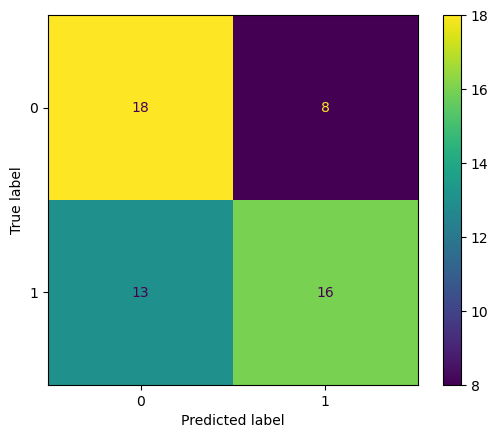

In [102]:
#get confusion matrix

# predict y's on X_test
y_pred = knn_pipeline.predict(X_test)

# generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
knn_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn_pipeline.named_steps['knn_classifier'].classes_)
knn_cm.plot()

# extract all the values from the confusion matrix
tn_knn, fp_knn, fn_knn, tp_knn = cm.ravel()

**No coefficients for knn models**

**Q2: Logistic Regression**

In [103]:
#variable selection
X = ha.drop(["output", "age"], axis = 1)
y = ha["output"]

In [104]:
#column transformer
ct = ColumnTransformer(
  [
    #drop = "first" should make it so that division is not included in the model
    ("dummify", OneHotEncoder(sparse_output = False, drop = "first"), ["sex", "cp", "restecg"]),
    ("standardize", StandardScaler(), ["trtbps", "thalach", "chol"]),
  ],
  remainder = "drop"
).set_output(transform = "pandas")

#interaction
# ColumnTransformer for interactions only
ct_inter = ColumnTransformer(
    [
    ("interaction_1", PolynomialFeatures(degree=2, interaction_only = True, include_bias=False), ["standardize__trtbps", "dummify__cp_1"]),
    ],
    remainder="passthrough"
)

#get col names
X_1 = ct.fit_transform(X)
#X_1

In [105]:
#logistic model pipeline
logistic_pipeline = Pipeline([
    ("preprocessing", ct),
    ("interaction", ct_inter),
    #got best C value to be 1
    ("logistic_regression", LogisticRegression(penalty="l2", C=1.0))
]).set_output(transform = "pandas")

In [106]:
#tune penalty parameter
Cs = {"logistic_regression__C": [0, .2, .4, .6, .8, 1]}

gscv = GridSearchCV(logistic_pipeline, Cs, cv = 5, scoring='roc_auc')

gscv_fitted = gscv.fit(X, y)

params_df = pd.DataFrame(gscv_fitted.cv_results_['params'])

results_df = params_df.assign(scores=gscv_fitted.cv_results_['mean_test_score'])

results_df.sort_values(by = 'scores', ascending = False).head()

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
5 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/pipeline.py", line 475, in fit
    self._final_estimator.f

,logistic_regression__C,scores
5,1.0,0.867399
4,0.8,0.867121
3,0.6,0.866576
2,0.4,0.861674
1,0.2,0.854026


In [107]:
#crossval score using roc auc
scores = cross_val_score(logistic_pipeline, X, y, cv=5, scoring='roc_auc')
roc_auc = scores.mean()
roc_auc

0.8673987621573829

For each model included below please note that only models that are found to have a higher ROC AUC score will be shown below:

1. model including every predictor: .8635

2. model including every predictor EXCEPT age: .8668

3. model including every predictor EXCEPT age AND interaction effect between trtbps and cp: .8673

In [108]:
#split to train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#fit data using final model
logistic_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('dummify',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['sex', 'cp', 'restecg']),
                                                 ('standardize',
                                                  StandardScaler(),
                                                  ['trtbps', 'thalach',
                                                   'chol'])])),
                ('interaction',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('interaction_1',
                                                  PolynomialFeatures(include_bias=False,
                                                                     interaction_only=True),
                                                  ['standardize__trtbps',
                                                   'dummify__cp_1'])])),
                ('logistic_regression', LogisticRegression())])

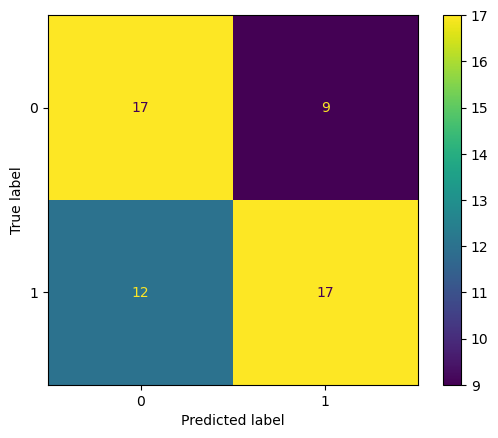

In [109]:
#confusion matrix
#get confusion matrix

# predict y's on X_test
y_pred = logistic_pipeline.predict(X_test)

# generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
logistic_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logistic_pipeline.named_steps['logistic_regression'].classes_)
logistic_cm.plot()

# extract vals from the coef matrix
tn_logistic, fp_logistic, fn_logistic, tp_logistic = cm.ravel()

In [110]:
#COPIED FROM CHATGPT NEED TO LOOK OVER

# Extract the logistic regression model after fitting
model = logistic_pipeline.named_steps["logistic_regression"]

# Get the transformed feature names from the ColumnTransformer
feature_names = ct.get_feature_names_out()

# Check if interaction terms are included, and update feature names
if "interaction" in logistic_pipeline.named_steps:
    feature_names = logistic_pipeline.named_steps["interaction"].get_feature_names_out(feature_names)

# Get the coefficients and intercept
coefficients = model.coef_.flatten()

# Combine feature names and coefficients into a DataFrame
import pandas as pd
coef_df = pd.DataFrame({"Feature": feature_names, "Coefficient": coefficients})

# Display the coefficients with feature names
print(coef_df)


                                            Feature  Coefficient
0                interaction_1__standardize__trtbps    -0.152991
1                      interaction_1__dummify__cp_1     1.802816
2  interaction_1__standardize__trtbps dummify__cp_1    -0.182385
3                         remainder__dummify__sex_1    -1.943648
4                          remainder__dummify__cp_2     1.474015
5                          remainder__dummify__cp_3     1.012682
6                     remainder__dummify__restecg_1     0.082311
7                     remainder__dummify__restecg_2    -0.166201
8                   remainder__standardize__thalach     1.227245
9                      remainder__standardize__chol    -0.248217
                                            Feature  Coefficient
0                interaction_1__standardize__trtbps    -0.152991
1                      interaction_1__dummify__cp_1     1.802816
2  interaction_1__standardize__trtbps dummify__cp_1    -0.182385
3                        

Some key coefficients that we observed in our model with their corresponding interpretation:

cp_1: 1.8 -> if the chest pain type is 1, the log-odds of being at risk of a heart attack increases by 1.8 when comparing to those with chest pain type = 4 (while holding everything else constant)

cp_1 and trtbps interaction: -0.182 -> the combined effect of resting blood pressure (standardized) and chest pain type 1 is assocaited with a .182 decrease in log odds of being at risk of a heart attack.

(1 = male, 0 = female)
sex: -1.94 -> if individual is male, the log odds of being at risk of a hearth attack decreases by 1.94 when compared to females

thalach: 1.22 -> For every one-unit increase in standardized maximum heart rate achieved during excersize, the log-odds of being at risk increase by 1.22.

**Q3: Decision Tree**

In [111]:
#variable selection
X = ha.drop(["output", "age", "chol"], axis = 1)
y = ha["output"]

In [112]:
#column transformer
ct = ColumnTransformer(
  [
    #drop = "first" should make it so that division is not included in the model
    ("dummify", OneHotEncoder(sparse_output = False, drop = "first"), ["sex", "cp", "restecg"]),
    ("standardize", StandardScaler(), ["trtbps", "thalach"]),
  ],
  remainder = "drop"
).set_output(transform = "pandas")

#interaction
# ColumnTransformer for interactions only
ct_inter = ColumnTransformer(
    [
    ("interaction_1", PolynomialFeatures(degree=2, interaction_only = True, include_bias=False), ["standardize__trtbps", "dummify__restecg_1"]),
    ],
    remainder="passthrough"
)

#get col names
X_1 = ct.fit_transform(X)
#X_1

In [113]:
#decision tree pipeline
decision_tree_pipeline = Pipeline([
    ("preprocessing", ct),
    ("interaction", ct_inter),
    #assuming that we dont need to tune logistic regression?
    ("decision_tree_classifier", DecisionTreeClassifier(ccp_alpha = .01))
]).set_output(transform = "pandas")

In [114]:
Ccps = {"decision_tree_classifier__ccp_alpha": [0, 0.001, 0.01, 0.1, 0.2, 0.5, 1.0, 3.0, 10.0]}

gscv = GridSearchCV(decision_tree_pipeline, Ccps, cv=5, scoring='roc_auc')

gscv_fitted = gscv.fit(X, y)

params_df = pd.DataFrame(gscv_fitted.cv_results_['params'])

results_df = params_df.assign(scores=gscv_fitted.cv_results_['mean_test_score'])

# Sort and display the top results
results_df.sort_values(by='scores', ascending=False).head()


,decision_tree_classifier__ccp_alpha,scores
2,0.010,0.730649
0,0.000,0.648327
1,0.001,0.640848
3,0.100,0.530069
4,0.200,0.500000


In [115]:
#crossval score using roc auc
scores = cross_val_score(decision_tree_pipeline, X, y, cv=5, scoring='roc_auc')
roc_auc = scores.mean()
roc_auc

0.7306489832007074

For each model included below please note that only models that are found to have a higher ROC AUC score will be shown below:

1. model including every predictor: .684

2. model including every predictor EXCEPT age: .712

3. model including every predictor EXCEPT age AND interaction effect between trtbps and restecg: .716

4. model including every predictor EXCEPT c(age, chol) AND interaction effect between trtbps and restecg: .7306

In [116]:
#split to train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#fit data using final model
decision_tree_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('dummify',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['sex', 'cp', 'restecg']),
                                                 ('standardize',
                                                  StandardScaler(),
                                                  ['trtbps', 'thalach'])])),
                ('interaction',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('interaction_1',
                                                  PolynomialFeatures(include_bias=False,
                                                                     interaction_only=True),
                                                  ['standardize__trtbps',
                                                   'dummify__restecg_1'])])),
                ('decision_tree_classifier',
                 DecisionTreeClassifier(ccp_alpha=0.01))])

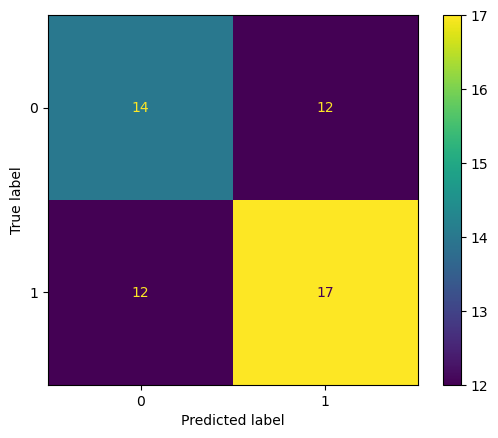

In [117]:
#confusion matrix
#get confusion matrix

# predict y's on X_test
y_pred = decision_tree_pipeline.predict(X_test)

# generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
tree_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=decision_tree_pipeline.named_steps['decision_tree_classifier'].classes_)
tree_cm.plot()

# extract all the values from the confusion matrix
tn_tree, fp_tree, fn_tree, tp_tree = cm.ravel()

**No coefficients for decision trees**

**Q4: Interpretation**

Which predictors were most important to predicting heart attack risk?

Some of the most important predictors to predicting heart attack risk are the following:

* cp
* sex
* thalach

There are other variables that are also somewhat important but the two that I found actually decreased my roc auc score in my cross validation scores tend to be the following variables:

* chol
* age

**Q5: ROC Curve**

Plot the ROC Curve for your three models above.

In [118]:
#knn
#variable selection
X = ha.drop(["output", "chol"], axis = 1)
y = ha["output"]
#split to train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#fit pipeline with data
knn_pipeline.fit(X_train, y_train)
#calculates probabities for all class types (so in this case just 0 and 1)
knn_probs = knn_pipeline.predict_proba(X_test)[:, 1]
#calculate false positive rate (FPR) and true positive rate (TPR)
knn_fpr, knn_tpr, _ = roc_curve(y_test, knn_probs)


#logistic
#variable selection
X = ha.drop(["output", "age"], axis = 1)
y = ha["output"]
#split to train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#fit pipeline with data
logistic_pipeline.fit(X_train, y_train)
#calculates probabities for all class types (so in this case just 0 and 1)
logistic_probs = logistic_pipeline.predict_proba(X_test)[:, 1]
#calculate false positive rate (FPR) and true positive rate (TPR)
logistic_fpr, logistic_tpr, _ = roc_curve(y_test, logistic_probs)

#tree
#variable selection
X = ha.drop(["output", "age", "chol"], axis = 1)
y = ha["output"]
#split to train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#fit pipeline with data
decision_tree_pipeline.fit(X_train, y_train)
#calculates probabities for all class types (so in this case just 0 and 1)
tree_probs = decision_tree_pipeline.predict_proba(X_test)[:, 1]
#calculate false positive rate (FPR) and true positive rate (TPR)
tree_fpr, tree_tpr, _ = roc_curve(y_test, tree_probs)


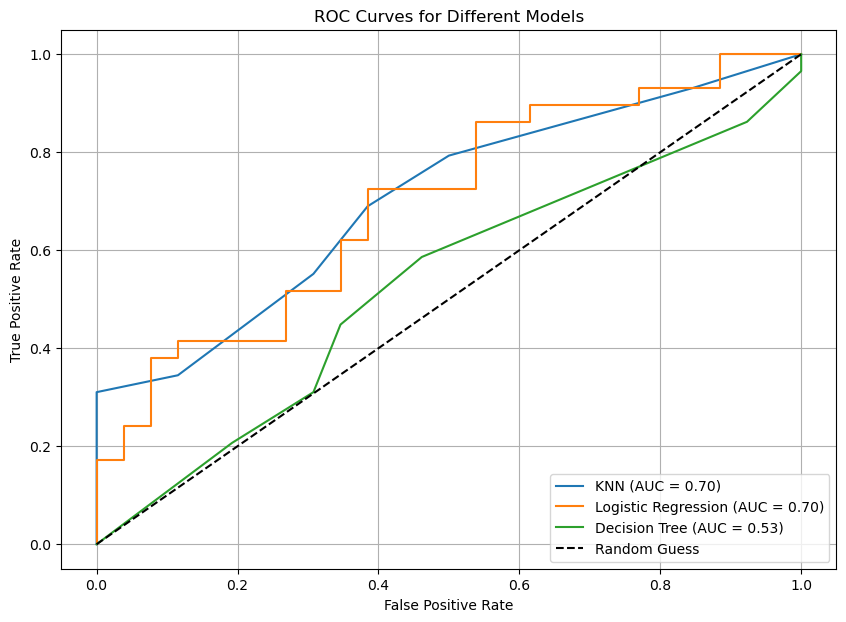

In [144]:
# calc AUC
knn_auc = auc(knn_fpr, knn_tpr)
logistic_auc = auc(logistic_fpr, logistic_tpr)
tree_auc = auc(tree_fpr, tree_tpr)

# plot ROC
plt.figure(figsize=(10, 7))

#legend
plt.plot(knn_fpr, knn_tpr, label=f'KNN (AUC = {knn_auc:.2f})')
plt.plot(logistic_fpr, logistic_tpr, label=f'Logistic Regression (AUC = {logistic_auc:.2f})')
plt.plot(tree_fpr, tree_tpr, label=f'Decision Tree (AUC = {tree_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

#labs
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curves for Various Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


**Part Two: Metrics**

Consider the following metrics:

* True Positive Rate or Recall or Sensitivity = Of the observations that are truly Class A, how many were predicted to be Class A?

* Precision or Positive Predictive Value = Of all the observations classified as Class A, how many of them were truly from Class A?

* True Negative Rate or Specificity or Negative Predictive Value = Of all the observations classified as NOT Class A, how many were truly NOT Class A?

Compute each of these metrics (cross-validated) for your three models (KNN, Logistic Regression, and Decision Tree) in Part One.

**KNN**

In [120]:
#True Positive Rate or Recall or Sensitivity = Of the observations that are truly Class A, how many were predicted to be Class A?
recall = tp_knn / (tp_knn + fn_knn)

#Precision or Positive Predictive Value = Of all the observations classified as Class A, how many of them were truly from Class A?
precision = tp_knn / (tp_knn + fp_knn)

#True Negative Rate or Specificity or Negative Predictive Value = Of all the observations classified as NOT Class A, how many were truly NOT Class A?
specificity = tn_knn / (tn_knn + fp_knn)

print("recall: ", recall, " precision: ", precision, " specificity: ", specificity)

recall:  0.5517241379310345  precision:  0.6666666666666666  specificity:  0.6923076923076923
recall:  0.5517241379310345  precision:  0.6666666666666666  specificity:  0.6923076923076923


**Logistic Regression**

In [121]:
#True Positive Rate or Recall or Sensitivity = Of the observations that are truly Class A, how many were predicted to be Class A?
recall = tp_logistic / (tp_logistic  + fn_logistic)

#Precision or Positive Predictive Value = Of all the observations classified as Class A, how many of them were truly from Class A?
precision = tp_logistic  / (tp_logistic  + fp_logistic)

#True Negative Rate or Specificity or Negative Predictive Value = Of all the observations classified as NOT Class A, how many were truly NOT Class A?
specificity = tn_logistic  / (tn_logistic  + fp_logistic)

print("recall: ", recall, " precision: ", precision, " specificity: ", specificity)

recall:  0.5862068965517241  precision:  0.6538461538461539  specificity:  0.6538461538461539
recall:  0.5862068965517241  precision:  0.6538461538461539  specificity:  0.6538461538461539


**Decision Tree**

In [122]:
#True Positive Rate or Recall or Sensitivity = Of the observations that are truly Class A, how many were predicted to be Class A?
recall = tp_tree / (tp_tree  + fn_tree)

#Precision or Positive Predictive Value = Of all the observations classified as Class A, how many of them were truly from Class A?
precision = tp_tree  / (tp_tree  + fp_tree)

#True Negative Rate or Specificity or Negative Predictive Value = Of all the observations classified as NOT Class A, how many were truly NOT Class A?
specificity = tn_tree  / (tn_tree  + fp_tree)

print("recall: ", recall, " precision: ", precision, " specificity: ", specificity)

recall:  0.5862068965517241  precision:  0.5862068965517241  specificity:  0.5384615384615384
recall:  0.5862068965517241  precision:  0.5862068965517241  specificity:  0.5384615384615384


**Part Three: Discussion**

Suppose you have been hired by a hospital to create classification models for heart attack risk.

The following questions give a possible scenario for why the hospital is interested in these models. For each one, discuss:

* Which metric(s) you would use for model selection and why.

* Which of your final models (Part One Q1-3) you would recommend to the hospital, and why.

* What score you should expect for your chosen metric(s) using your chosen model to predict future observations.

**Q1: The hospital faces severe lawsuits if they deem a patient to be low risk, and that patient later experiences a heart attack.**

Q1 is saying that the hospital gets severe lawsuits if they have a type II error. 
Because of this, we want to minimize our risk of a type II error. In other words, we want the model that has the highest specificity.

This is because specificity indicates the true negative rate.

Our final knn model has a specificity rate of 0.692 (highest value).

So I would recommend using the knn model.

**Q2: The hospital is overfull, and wants to only use bed space for patients most in need of monitoring due to heart attack risk.**

Q2 is saying that they need to make sure they are only using bed space for people with an actual heart attack risk. This means that they want to make sure that the proportion of actual positives are identified correctly.

This would be the model with the highest precision.

Both our knn and logistic regression model have extremely comparable and the highest precision (~.66)

Because our knn model has a lower recall score as well as a lower cross validated roc auc score, it would be better to recommend the logistic regression model to the hospital

metrics: 
* cross validated roc_auc score: .86
* precision score: .65

**Q3: The hospital is studying root causes of heart attacks, and would like to understand which biological measures are associated with heart attack risk.**

Q3 is saying that the hospital wants the model that best predicts heart rate using whatever variables needed in the dataset.

Because our logistic regression model has a very comparable precision (1%) less score to our knn model BUT also has a higher roc auc score when comparing to our knn model (3% more). I would recommend the hospital use this model when wanting to understand which biological measures are associated with heart attack.

Metrics:
* precision score: .65
* cross validated roc_auc score: .86

**Q4: The hospital is training a new batch of doctors, and they would like to compare the diagnoses of these doctors to the predictions given by the algorithm to measure the ability of new doctors to diagnose patients.**

Q4 is asking which model provides the best overall performance in measuring whether or not a patient is at heart attack risk. We want this because it will be the best to be compared to the doctors diagnostic accuracy (which is why we want the highest value).

From our final models we get that our highest cross validated roc auc score is .86 (which comes from our logistic regression model)

Additionally metrics such as precision and recall can also be important in order to minimize unaccurate diagnoses. With that in mind, the logistic regression model best overall fits these metrics we want.

Metrics:
* precision score: .65
* recall score: .586
* cross validated roc_auc score: .86


**Part Four: Validation**

Use each of your final models in Part One Q1-3, predict the target variable in the validation dataset.

For each, output a confusion matrix, and report the ROC AUC, the precision, and the recall.

Compare these values to the cross-validated estimates you reported in Part One and Part Two. Did our measure of model success turn out to be approximately correct for the validation data?

In [123]:
#read in data
ha_validation = pd.read_csv("https://www.dropbox.com/s/jkwqdiyx6o6oad0/heart_attack_validation.csv?dl=1")

**KNN**

In [124]:
#variable selection
X_train = ha.drop(["output", "chol"], axis = 1)
y_train = ha["output"]

X_test = ha_validation.drop(["output", "chol"], axis = 1)
y_test = ha_validation["output"]

In [125]:
#crossval score using roc auc
scores = cross_val_score(knn_pipeline, X_test, y_test, cv=5, scoring='roc_auc')
roc_auc = scores.mean()
roc_auc

0.5722222222222222

In [126]:
#precision and recall
#fit data using final model
knn_pipeline.fit(X_train, y_train)

#get confusion matrix
# predict y's on X
y_pred = knn_pipeline.predict(X_test)

# generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# extract all the values from the confusion matrix
tn_knn, fp_knn, fn_knn, tp_knn = cm.ravel()

#True Positive Rate or Recall or Sensitivity = Of the observations that are truly Class A, how many were predicted to be Class A?
recall = tp_knn / (tp_knn + fn_knn)

#Precision or Positive Predictive Value = Of all the observations classified as Class A, how many of them were truly from Class A?
precision = tp_knn / (tp_knn + fp_knn)

print("recall: ", recall, " precision: ", precision)

recall:  0.6842105263157895  precision:  0.8125
recall:  0.6842105263157895  precision:  0.8125


**Logistic Regresion**

In [127]:
#variable selection
X_train = ha.drop(["output", "age"], axis = 1)
y_train = ha["output"]

X_test = ha_validation.drop(["output", "age"], axis = 1)
y_test = ha_validation["output"]

In [128]:
#crossval score using roc auc
scores = cross_val_score(logistic_pipeline, X_test, y_test, cv=5, scoring='roc_auc')
roc_auc = scores.mean()
roc_auc

0.675

In [129]:
#precision and recall
#fit data using final model
logistic_pipeline.fit(X_train, y_train)

#get confusion matrix
# predict y's on X
y_pred = logistic_pipeline.predict(X_test)

# generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# extract all the values from the confusion matrix
tn_logistic, fp_logistic, fn_logistic, tp_logistic = cm.ravel()

#True Positive Rate or Recall or Sensitivity = Of the observations that are truly Class A, how many were predicted to be Class A?
recall = tp_logistic / (tp_logistic + fn_logistic)

#Precision or Positive Predictive Value = Of all the observations classified as Class A, how many of them were truly from Class A?
precision = tp_logistic / (tp_logistic + fp_logistic)

print("recall: ", recall, " precision: ", precision)

recall:  0.7894736842105263  precision:  0.8333333333333334
recall:  0.7894736842105263  precision:  0.8333333333333334


**Decision Tree**

In [130]:
#variable selection
X_train = ha.drop(["output", "age", "chol"], axis = 1)
y_train = ha["output"]

X_test = ha_validation.drop(["output", "age", "chol"], axis = 1)
y_test = ha_validation["output"]

In [131]:
#crossval score using roc auc
scores = cross_val_score(decision_tree_pipeline, X_test, y_test, cv=5, scoring='roc_auc')
roc_auc = scores.mean()
roc_auc

0.5083333333333333

In [132]:
#precision and recall
#fit data using final model
decision_tree_pipeline.fit(X_train, y_train)

#get confusion matrix
# predict y's on X
y_pred = decision_tree_pipeline.predict(X_test)

# generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# extract all the values from the confusion matrix
tn_tree, fp_tree, fn_tree, tp_tree = cm.ravel()

#True Positive Rate or Recall or Sensitivity = Of the observations that are truly Class A, how many were predicted to be Class A?
recall = tp_tree / (tp_tree + fn_tree)

#Precision or Positive Predictive Value = Of all the observations classified as Class A, how many of them were truly from Class A?
precision = tp_tree / (tp_tree + fp_tree)

print("recall: ", recall, " precision: ", precision)

recall:  0.7368421052631579  precision:  0.875
recall:  0.7368421052631579  precision:  0.875


**Overall Notes:**

Knn Model:
* lower roc_auc score (from 0.835494 to .572)
* higher recall score (now 0.684)
* higher precision score (now 0.8125)

Logistic Regression Model:
* lower roc_auc score (from .867 to .675)
* high recall score (now 0.789)
* high precision score (now 0.833)

Decision Tree Model:
* lower roc_auc score (from .730 to .558)
* high recall score (now .736)
* high precision score (now .875)

It makes sense that the roc_auc score decreased significantly. We originally created our final model to optimize our roc_auc for our original data (that includes variable selection, interactions, and tuning). Now that we have a new dataset (especially a small one), it makes sense that it wouldn't fit our model as well as the data that was used to create it.

It does appear that our model success is approximiately correct with our validation data, although our roc_auc score isn't as high as we would like, we are still observed a significant increase in our recall and precision score for EVERY model used.

**Part Five: Cohen’s Kappa**

Another common metric used in classification is Cohen’s Kappa.

Use online resources to research this measurement. Calculate it for the models from Part One, Q1-3, and discuss reasons or scenarios that would make us prefer to use this metric as our measure of model success. Do your conclusions from above change if you judge your models using Cohen’s Kappa instead? Does this make sense?

**KNN**

In [133]:
#variable selection
X_train = ha.drop(["output", "chol"], axis = 1)
y_train = ha["output"]

X_test = ha_validation.drop(["output", "chol"], axis = 1)
y_test = ha_validation["output"]

In [134]:
#calculate cohen's kappa
from sklearn.metrics import cohen_kappa_score

# Fit the pipeline on the training data
knn_pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = knn_pipeline.predict(X_test)

# Calculate Cohen's Kappa
kappa = cohen_kappa_score(y_test, y_pred)

print("Cohen's Kappa: ", kappa)


Cohen's Kappa:  0.38914027149321273
Cohen's Kappa:  0.38914027149321273


**Logistic Regression**

In [135]:
#variable selection
X_train = ha.drop(["output", "age"], axis = 1)
y_train = ha["output"]

X_test = ha_validation.drop(["output", "age"], axis = 1)
y_test = ha_validation["output"]

In [136]:
#calculate cohen's kappa
# Fit the pipeline on the training data
logistic_pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = logistic_pipeline.predict(X_test)

# Calculate Cohen's Kappa
kappa = cohen_kappa_score(y_test, y_pred)

print("Cohen's Kappa: ", kappa)

Cohen's Kappa:  0.5070422535211268
Cohen's Kappa:  0.5070422535211268


**Decision Tree**

In [137]:
#variable selection
X_train = ha.drop(["output", "age", "chol"], axis = 1)
y_train = ha["output"]

X_test = ha_validation.drop(["output", "age", "chol"], axis = 1)
y_test = ha_validation["output"]

In [138]:
#calculate cohen's kappa
# Fit the pipeline on the training data
decision_tree_pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = decision_tree_pipeline.predict(X_test)

# Calculate Cohen's Kappa
kappa = cohen_kappa_score(y_test, y_pred)

print("Cohen's Kappa: ", kappa)

Cohen's Kappa:  0.5248868778280543
Cohen's Kappa:  0.5248868778280543


I was able to find that cohens kappa is a measurement that evaluates how well we are predicting our response (whether or not someone is at heart risk) this is recorded as an agreement score. Once you see how you did in comparing train to test, the cohen's kappa adjusts the "agreement score" to account for the possibly of the model just getting the right answer by chance. (this is because its 50/50 on the right category).

The formula used is:
k = (po - pe) / (1 - pe) 
where po is the observed agreement score and pe is the expected agreement score

Our kappa value can be values less than 1 where:
* =1: perfect agreement between predictors and outcome
* <1: agreement is no better than randomly guessing
* <0: the model is worse than randomly guessing

Some of the main reasons we would want to use this in this case is if there is an imbalance in our binary variable (so for example if 70% of our data was 0, then our model could just pick 0 most of the time and be very accurate).

I definitely think that the conclusions we made should change (atleast a little). I find it very interesting that our decision tree method has the highest cohen's kappa. I think other than that it aligns with our previous results pretty well. I was predicting that logistic regression would have the highest as it has overall been performing the best compared to the 3 models. On average it had the highest collective roc_auc, precision, and recall scores.

I think that although our final conclusions from the model have changed a bit, it makes the most sense to use cohen's kappa in this case.

Below is the code to see the counts of both our train and test dataset to see if cohen's kappa is infact the best choice for our data (this would be if there wasn't a good split because 1s and 0s for our response variable)

In [139]:
counts = ha['output'].value_counts()
print(counts)


output
1    146
0    127
Name: count, dtype: int64
output
1    146
0    127
Name: count, dtype: int64


In [140]:
counts = ha_validation['output'].value_counts()
print(counts)

output
1    19
0    11
Name: count, dtype: int64
output
1    19
0    11
Name: count, dtype: int64


So for our first dataset we can see that there is a very fair split, but for our second, there is almost twice as many observations that fall into the "has heart risk" category versus the "no heart risk" category. This would call for a good use of cohen's kappa